# Chapter6. Temporal Difference
---

### Import grid environment

In [151]:
import import_ipynb
from grid_env_55 import GridEnv, policy_visualize, ActionValueFunction_visualize
from tqdm import tqdm

import numpy as np
import random
import time
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Generate Greedy Policy

In [152]:
def GreedyPolicy_generation(env, Q):
    """
    Generate Greedy Policy with Q value
    """
    policy = np.zeros([len(env.obs_space), len(env.action_space)])
    for s in range(len(env.obs_space)):
        if s == 99:
            continue
            
        max_actions = np.where(Q[s] == np.max(Q[s]))[0]
        GreedyAction = np.random.choice(max_actions)
        
        policy[s][GreedyAction] = 1
            
    return policy

### Generate Epsilon Greedy Policy

In [153]:
# 4 actions and 100 states -> 4x100 size
def EpsilsonGreedyPolicy_generation(env, Q, e=0.1):
    policy = np.zeros([len(env.obs_space), len(env.action_space)])
    
    for s in range(len(env.obs_space)):
        GreedyActions = np.where(Q[s] == np.max(Q[s]))[0]
        GreedyAction = random.choice(GreedyActions)
        NonGreedyActions = [a for a in env.action_space if a != GreedyAction]
        
        policy[s][GreedyAction] = 1 - e + e/len(env.action_space)
        for a in NonGreedyActions:
            policy[s][a] = e/len(env.action_space)
            
    return policy

In [154]:
env = GridEnv()

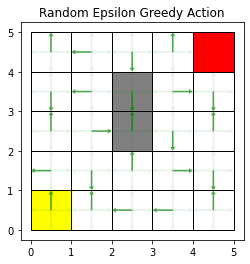

In [155]:
Q = np.zeros([100, 4])
policy = EpsilsonGreedyPolicy_generation(env, Q, e=0.4)
policy_visualize(env, policy, "Random Epsilon Greedy Action")

### Decaying Epsilon

In [156]:
def update_epsilon(t):
    if t < 100:
        return 1
    elif 100 <= t < 1000:
        return 0.8
    elif 1000 <= t < 10000:
        return 0.4
    else:
        return 0.2

### 1. SARSA: On policy TD control
- Save, but it takes some time to convergence
- Enough small alpha and decaying epsilon are needed to convergence
- $Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[R_{t+1}+ \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right]$

In [165]:
def SARSA(env, loop, gamma=0.99, alpha=0.1):
    '''
    On Policy TD Control 'SARSA' with decaying epsilon
    '''
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    Q = np.zeros([n_state, n_action])
    Q_history = [np.zeros([n_state, n_action])]
    policy_history = []
    Convergence = []
    
    for i in tqdm(range(loop)):
        # initialize S
        S = env.reset()
        
        e = update_epsilon(i)
        policy = EpsilsonGreedyPolicy_generation(env, Q, e)
        A = random.choices(env.action_space, weights=policy[S])[0]
        while True:
            R_nxt, S_nxt, done, info = env.step(A)
            A_nxt = random.choices(env.action_space, weights=policy[S_nxt])[0]
            
            Q[S][A] = Q[S][A] + alpha*(R_nxt + gamma*Q[S_nxt][A_nxt] - Q[S][A])
            policy = EpsilsonGreedyPolicy_generation(env, Q, e)

            S = S_nxt
            A = A_nxt
            
            if done:
                break
    
        Q_store = deepcopy(Q)
        policy_store = deepcopy(policy)
        policy_history.append(policy_store)
        Q_history.append(Q_store)
        Convergence.append(np.sum(Q_store))
    
    return Q, Q_history, Convergence, policy, policy_history

#### 1.1. Run SARSA

In [166]:
start = time.time()
Q, Q_history, Convergence, TargetPolicy, policy_history = SARSA(env, 100000, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 100000/100000 [06:24<00:00, 260.02it/s]


It took [384.59]s.
Policy evaluation converged in [100001] loops.


#### 1.2. Plot the convergence of SARSA

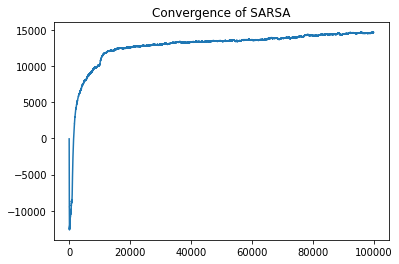

In [167]:
plt.plot(Convergence)
plt.title("Convergence of SARSA")
plt.show()

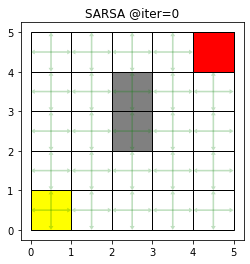

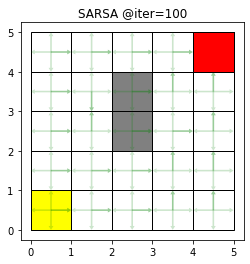

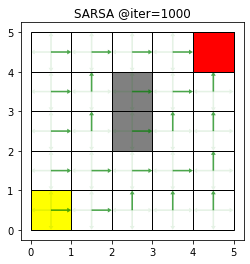

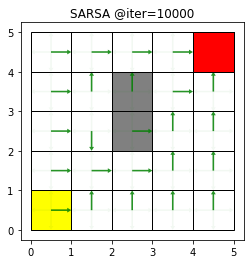

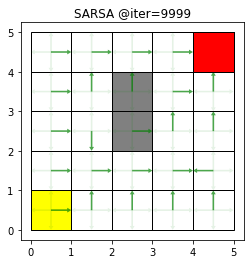

In [168]:
for i in [0,100,1000,10000,10000-1]:
    policy_visualize(env, policy_history[i], "SARSA @iter={}".format(i))

#### 1.3. Visualize Optimal Policy and Optimal Action Value Function

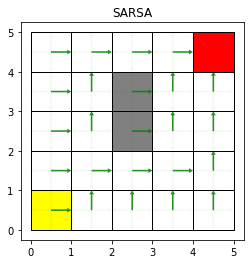

In [169]:
policy_visualize(env, TargetPolicy, "SARSA")

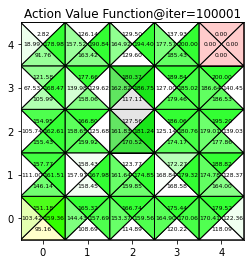

In [170]:
ActionValueFunction_visualize(env, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))

### 2. Q-Learning: Off policy TD control

- $Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[R_{t+1}+ \gamma \max_{a} Q(S_{t+1},a) - Q(S_t,A_t) \right]$

In [171]:
def Q_Learning(env, loop, gamma=0.99, alpha=0.1):
    '''
    Off Policy TD Control 'Q Learning' with decaying epsilon
    '''
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    Q = np.zeros([n_state, n_action])
    Q_history = [np.zeros([n_state, n_action])]
    Convergence = []
    
    for i in tqdm(range(loop)):
        # initialize S
        S = env.reset()
        e = update_epsilon(i)
        
        while True:
            policy = EpsilsonGreedyPolicy_generation(env, Q, e)
            A = random.choices(env.action_space, weights=policy[S])[0]
            R_nxt, S_nxt, done, info = env.step(A)
            
            Q[S][A] = Q[S][A] + alpha*(R_nxt + gamma*np.max(Q[S_nxt]) - Q[S][A])

            S = S_nxt
            
            if done:
                break
    
        Q_store = deepcopy(Q)
        Q_history.append(Q_store)
        Convergence.append(np.sum(Q_store))
    
    return Q, Q_history, Convergence, policy

#### 2.1. Run Q Learning

In [172]:
start = time.time()
Q, Q_history, Convergence, TargetPolicy = Q_Learning(env, 10000, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 10000/10000 [00:53<00:00, 188.31it/s]



It took [53.18]s.
Policy evaluation converged in [10001] loops.


#### 2.2. Plot the convergence of Q Learning

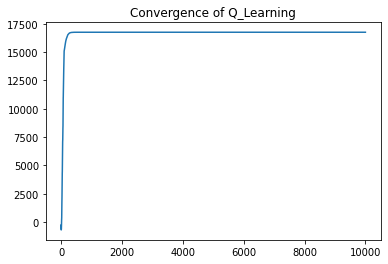

In [173]:
plt.plot(Convergence)
plt.title("Convergence of Q_Learning")
plt.show()

#### 2.3. Visualize Optimal Policy and Optimal Action Value Function

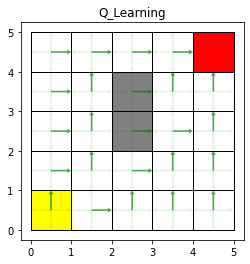

In [174]:
policy_visualize(env, TargetPolicy, "Q_Learning")

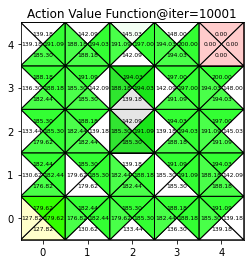

In [175]:
ActionValueFunction_visualize(env, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))

### 3. Expected SARSA: On policy TD control

- $Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left[R_{t+1}+ \gamma \underset{a}{\sum} \pi(a|S_{t+1})Q(S_{t+1},a) - Q(S_t,A_t) \right]$

In [176]:
def ExpectedSARSA(env, loop, gamma=0.99, alpha=0.1):
    '''
    Off Policy TD Control 'Expected SARSA' with decaying epsilon
    '''
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    Q = np.zeros([n_state, n_action])
    Q_history = [np.zeros([n_state, n_action])]
    Convergence = []
    
    for i in tqdm(range(loop)):
        env.reset()
        
        # initialize S
        S = random.choices(list(env.obs_space.keys()))[0]
        e = update_epsilon(i)
        
        while True:
            policy = EpsilsonGreedyPolicy_generation(env, Q, e)
            A = random.choices(env.action_space, weights=policy[S])[0]
            R_nxt, S_nxt, done, info = env.step(A)
            
            
            SigmaPiQ_nxt = 0
            for A_nxt, pi_nxt in enumerate(policy[S_nxt]):
                SigmaPiQ_nxt += pi_nxt*Q[S_nxt][A_nxt]
            
            Q[S][A] = Q[S][A] + alpha*(R_nxt + gamma*SigmaPiQ_nxt - Q[S][A])

            S = S_nxt
            
            if done:
                break
    
        Q_store = deepcopy(Q)
        Q_history.append(Q_store)
        Convergence.append(np.sum(Q_store))
    
    return Q, Q_history, Convergence, policy

#### 3.1. Run Expected SARSA

In [177]:
start = time.time()
Q, Q_history, Convergence, TargetPolicy = Q_Learning(env, 10000, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 10000/10000 [00:52<00:00, 190.27it/s]


It took [52.56]s.
Policy evaluation converged in [10001] loops.


#### 3.2. Plot the convergence of Expected SARSA

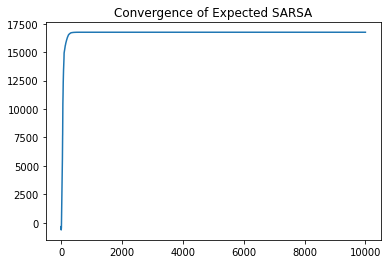

In [178]:
plt.plot(Convergence)
plt.title("Convergence of Expected SARSA")
plt.show()

#### 3.3. Visualize Optimal Policy and Optimal Action Value Function

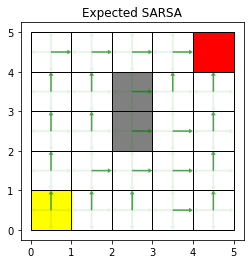

In [179]:
policy_visualize(env, TargetPolicy, "Expected SARSA")

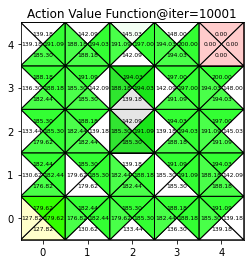

In [180]:
ActionValueFunction_visualize(env, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))

### 4. Double Q Learning
- It is not affected by maximization bias
- $Q_1(S_t,A_t) \leftarrow Q_1(S_t,A_t) + \alpha \left[R_{t+1}+ \gamma Q_2(S_{t+1}, \underset{a}{\text{argmax}} Q_1(S_{t+1},a)) - Q_1(S_t,A_t) \right]$

In [181]:
def DoubleQLearning(env, loop, gamma=0.99, alpha=0.1):
    '''
    Off Policy TD Control 'Q Learning' with decaying epsilon
    '''
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    Q1 = np.zeros([n_state, n_action])
    Q2 = np.zeros([n_state, n_action])
    Q1_history = [np.zeros([n_state, n_action])]
    Convergence = []
    
    for i in tqdm(range(loop)):
        # initialize S
        S = env.reset()
        e = update_epsilon(i)
        
        while True:
            policy = EpsilsonGreedyPolicy_generation(env, Q1+Q2, e)
            A = random.choices(env.action_space, weights=policy[S])[0]
            R_nxt, S_nxt, done, info = env.step(A)
            
            if np.random.randint(2):
                GreedyActions = np.where(Q1[S_nxt] == np.max(Q1[S_nxt]))[0]
                GreedyAction = random.choice(GreedyActions) 
                Q1[S][A] = Q1[S][A] + alpha*(R_nxt + gamma*Q2[S_nxt][GreedyAction] - Q1[S][A])
            else:
                GreedyActions = np.where(Q2[S_nxt] == np.max(Q2[S_nxt]))[0]
                GreedyAction = random.choice(GreedyActions) 
                Q2[S][A] = Q2[S][A] + alpha*(R_nxt + gamma*Q1[S_nxt][GreedyAction] - Q2[S][A])

            S = S_nxt
            if done:
                break
    
        Q_store = deepcopy(Q1)
        Q_history.append(Q_store)
        Convergence.append(np.sum(Q_store))
    
    return Q, Q_history, Convergence, policy

#### 4.1. Run Double Q Learning

In [182]:
start = time.time()
Q, Q_history, Convergence, TargetPolicy = DoubleQLearning(env, 10000, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 10000/10000 [00:56<00:00, 178.29it/s]


It took [56.09]s.
Policy evaluation converged in [20001] loops.


#### 4.2. Plot the convergence of Double Q Learning

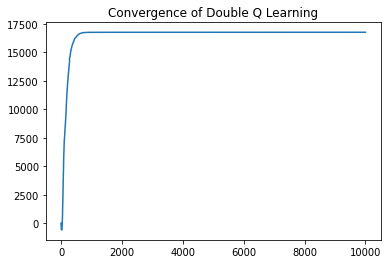

In [183]:
plt.plot(Convergence)
plt.title("Convergence of Double Q Learning")
plt.show()

#### 4.3. Visualize Optimal Policy and Optimal Action Value Function

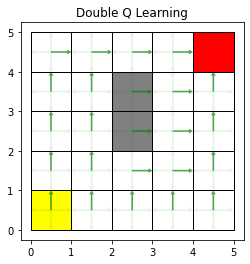

In [184]:
policy_visualize(env, TargetPolicy, "Double Q Learning")

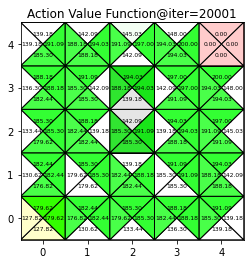

In [185]:
ActionValueFunction_visualize(env, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))

#### 4.4 10x10 Grid Environment

In [128]:
from grid_env import GridEnv, policy_visualize, ActionValueFunction_visualize

importing Jupyter notebook from GridEnv.ipynb


In [129]:
env1010 = GridEnv()

In [133]:
def update_epsilon(t):
    if t < 1000:
        return 1
    elif 1000 <= t < 10000:
        return 0.8
    elif 10000 <= t < 50000:
        return 0.6
    elif 50000 <= t < 100000:
        return 0.4
    else:
        return 0.2

In [134]:
start = time.time()
Q, Q_history, Convergence, TargetPolicy = DoubleQLearning(env1010, 100000, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 100000/100000 [1:40:47<00:00, 16.54it/s] 


It took [6047.78]s.
Policy evaluation converged in [701513] loops.


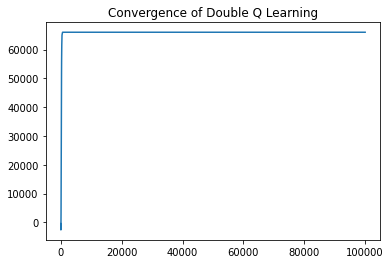

In [135]:
plt.plot(Convergence)
plt.title("Convergence of Double Q Learning")
plt.show()

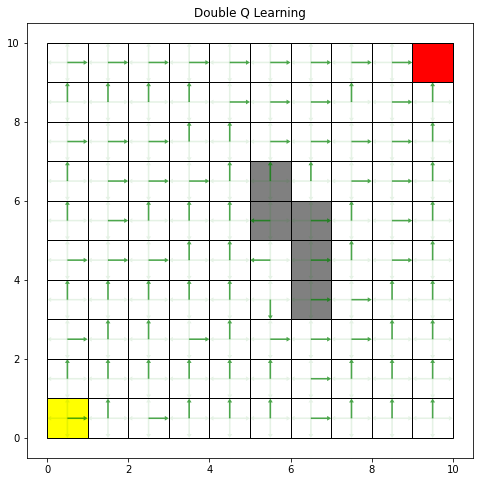

In [136]:
policy_visualize(env1010, TargetPolicy, "Double Q Learning")

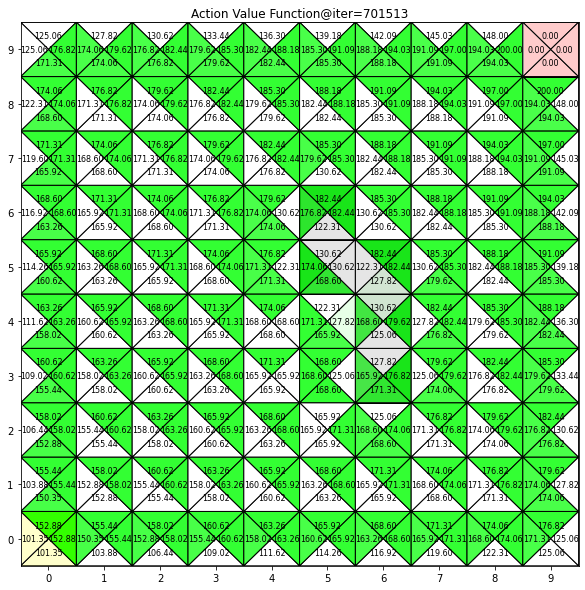

In [137]:
ActionValueFunction_visualize(env1010, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))